In [1]:
from scripts.temp_ml_scripts import *

## Load time series

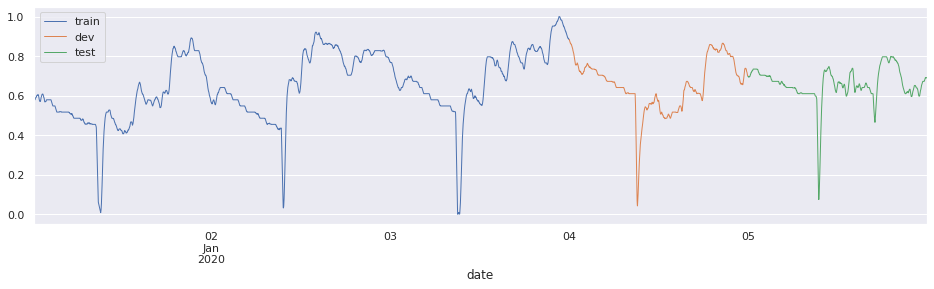

In [2]:
# Load time series data
time_series = pd.read_csv('data/time_series.csv', index_col='date').asfreq('T')['temp']

# Chop series for developing
time_series = time_series.loc['2020-01-01':'2020-01-05'] # 5 days

# Normalize the data (particlularly important for NNs)
min_value = np.min(time_series)
max_value = np.max(time_series)
time_series = (time_series - min_value)/(max_value - min_value)

def un_normalize_series(series):
    original = series * (max_value - min_value) + min_value
    return original
    
# Size of dev and test sets (in same units as time_series: minutes)
size_dev = 60 * 24 * 1 # one day
size_test = 60 * 24 * 1 # one day

# Split time series into train, dev and test sets
time_series_train, time_series_dev, time_series_test = train_dev_test_split(time_series, size_dev, size_test)  # for implementation, see temp-utilities.py

# Plot the time series
plot_time_series(time_series_train, time_series_dev, time_series_test)  # for implementation, see temp-utilities.py

## DES - dev

In [3]:
# Set parameters
forecast_window_size = 10       # forecast 10 steps ahead
fit_window_size = 100           # fit the last 100 values
exponential = True              # additive time series 
damped = True                   # dampen the trend impact on forecast
history = time_series_train     # use train set as history
future = time_series_dev        # use dev set as future

# Forecasting
details, errors, forecast = Forecast(history, future,  # for implementation of Forecast(), see temp-math-scripts.py
                                     fit_window_size = fit_window_size, 
                                     forecast_window_size = forecast_window_size,
                                     model = 'DES', parameters = {'exponential':exponential, 'damped':damped})
score = np.mean(errors)

# Store named variables for comparison
DES_dev_forecast = forecast
DES_dev_errors = errors
DES_dev_score = score

## DES - test

In [4]:
# Set parameters
forecast_window_size = 10       # forecast 10 steps ahead
fit_window_size = 100           # fit the last 100 values
exponential = True              # additive time series 
damped = True                   # dampen the trend impact on forecast
history = time_series_dev       # use dev set as history
future = time_series_test       # use test set as future

# Forecasting
details, errors, forecast = Forecast(history, future,  # for implementation of Forecast(), see temp-math-scripts.py
                                     fit_window_size = fit_window_size, 
                                     forecast_window_size = forecast_window_size,
                                     model = 'DES', parameters = {'exponential':exponential, 'damped':damped})
score = np.mean(errors)

# Store named variables for comparison
DES_test_forecast = forecast
DES_test_errors = errors
DES_test_score = score

## RNN - dev

In [13]:
best_model = tf.keras.models.load_model('../input/temp-best-model/selected_best_model.h5')
n_steps_in = 10
n_steps_out = 10

# Forecasting
X_dev, y_dev, t_dev = split_sequence(time_series_dev, n_steps_in, n_steps_out)
forecast = direct_forecast(X_dev, y_dev, t_dev, best_model)     # for implementation of direct_forecast(), see temp-ml-scripts.py

# Scoring
errors, score = evaluate_model_performance(forecast)         # for implementation of evaluate_model_performance(), see temp-ml-scripts.py

# Store named variables for comparison
RNN_dev_forecast = forecast
RNN_dev_errors = errors
RNN_dev_score = score

## RNN - test

In [14]:
best_model = tf.keras.models.load_model('../input/temp-best-model/selected_best_model.h5')
n_steps_in = 10
n_steps_out = 10

# Forecasting
X_test, y_test, t_test = split_sequence(time_series_test, n_steps_in, n_steps_out)
forecast = direct_forecast(X_test, y_test, t_test, best_model)     # for implementation of direct_forecast(), see temp-ml-scripts.py

# Scoring
errors, score = evaluate_model_performance(forecast)         # for implementation of evaluate_model_performance(), see temp-ml-scripts.py

# Store named variables for comparison
RNN_test_forecast = forecast
RNN_test_errors = errors
RNN_test_score = score

## Comparison

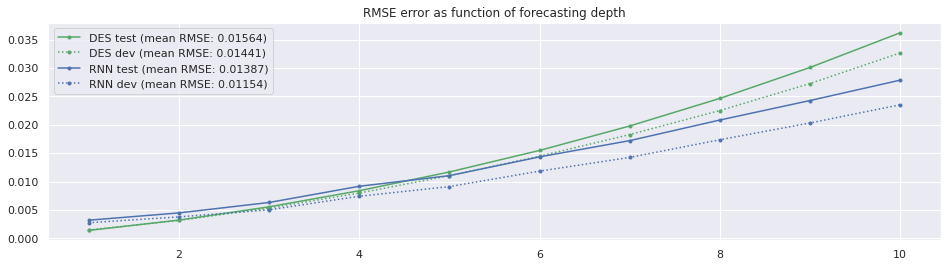

In [7]:
# Plot the errors as a function of the forecasting depth
plt.title('RMSE error as function of forecasting depth');
plt.plot(np.arange(1,forecast_window_size+1), DES_test_errors, 'g.-', label='DES test (mean RMSE: {:.5f})'.format(DES_test_score));
plt.plot(np.arange(1,forecast_window_size+1), DES_dev_errors, 'g.:', label='DES dev (mean RMSE: {:.5f})'.format(DES_dev_score));
plt.plot(np.arange(1,n_steps_out+1), RNN_test_errors, 'b.-', label='RNN test (mean RMSE: {:.5f})'.format(RNN_test_score));
plt.plot(np.arange(1,n_steps_out+1), RNN_dev_errors, 'b.:', label='RNN dev (mean RMSE: {:.5f})'.format(RNN_dev_score));
plt.legend();

Comments:
- The mathematical DES model (green) performs better at lower forecasting depth, while the machine learning RNN model (blue) performs better at high forecasting depth. The crossover occurs around a depth of 5 time steps. An ideal implementation could utilize DES for the first 4 steps and RNN for steps 5 through 10. Should one be interested in developing deeper forecasts, beyond ten time steps, then it is advisable to continue with the machine learning model.
- The plot shows a gap between the test and dev errors, indicating an overfitting to the dev set. Moreover, the gap seems to increases (at least in absolute numbers) for both methods. This is verified next by plotting the relative gap sizes. 
- The error on the 10-step forecast can be converted to a realistic error estimate in % on the temperature readings, taking into account the realistic range in temp values. This is discussed further below.

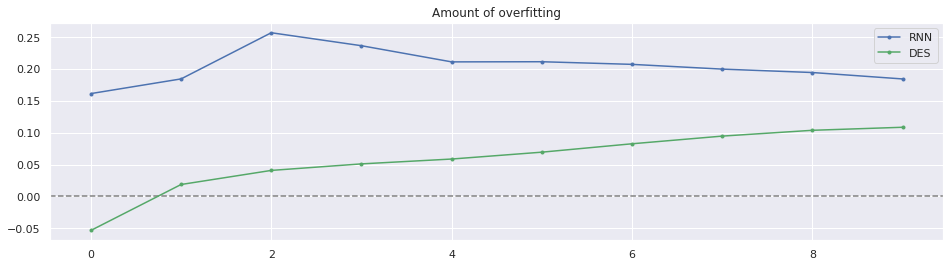

In [8]:
# Plot ratios test/dev errors
plt.axhline(y=0, xmin=0, xmax=10, color='gray', linestyle='--');
plt.plot(RNN_test_errors/RNN_dev_errors-1, 'b.-', label='RNN');
plt.plot(DES_test_errors/DES_dev_errors-1, 'g.-', label='DES');
plt.title('Amount of overfitting');
plt.legend();

Comments:
- The DES model shows less overfitting than the RNN model.
- On the other hand, the DES model shows monotonically increasing behaviour with the depth, while the RNN model is more or less constant. Whether there would be a crossover remains to be seen by future experiments.
- The stability of these conclusions could also be tested by varying or enlarging the test set.

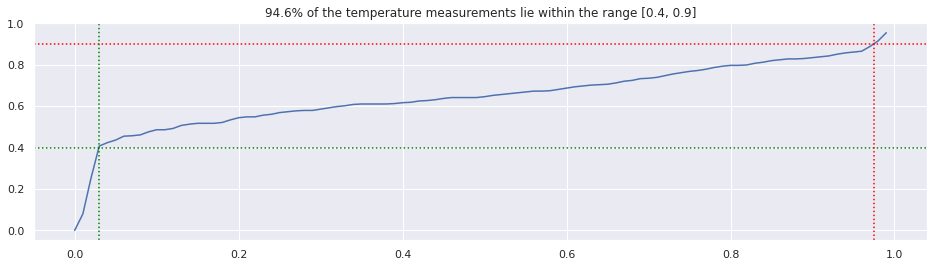

In [9]:
# Determine typical range of temperature values
x = np.arange(0,1,0.01)
y = time_series.quantile(x)
plt.plot(x,y);
temp_high = 0.9
temp_low = 0.4
temp_range = temp_high - temp_low
frac_right = (time_series>temp_high).astype(int).mean()
frac_left = (time_series<temp_low).astype(int).mean()
plt.axhline(y=temp_high, xmin=0, xmax=1, color='red', linestyle=':');
plt.axhline(y=temp_low, xmin=0, xmax=1, color='green', linestyle=':');
plt.axvline(x=1-frac_right, ymin=0, ymax=1, color='red', linestyle=':');
plt.axvline(x=frac_left, ymin=0, ymax=1, color='green', linestyle=':');
plt.title('{:.3}% of the temperature measurements lie within the range [{:.1}, {:.2}]'.format((1-frac_left-frac_right)*100,temp_low,temp_high));

In [10]:
# Compute error from DES on test set at 10-step forecasting depth
err = DES_test_errors[-1]
# Account for range of temperature values
rel_err = err/temp_range
print('Relative error DES (test) is {:.2}%'.format(rel_err*100))

Relative error DES (test) is 7.2%


In [11]:
# Compute error from RNN on test set at 10-step forecasting depth
err = RNN_test_errors[-1]
# Account for range of temperature values
rel_err = err/temp_range
print('Relative error RNN (test) is {:.2}%'.format(rel_err*100))

Relative error RNN (test) is 5.6%


In [12]:
# Improvement of RNN over DES model
impr = 1-RNN_test_errors[-1]/DES_test_errors[-1]
print('Improvement of RNN over DES model by {:.3}%'.format(impr*100))

Improvement of RNN over DES model by 23.0%
